In [58]:
velScale = 3.4482758620689656e-13*(3600*24*365)*100.  #cm/y
timeScale = 8.41e+18/(1e6*3600*24*365)    
tempScale = 1400.0
stressScale = 11.890606

#adiabatTempGrad = 0.814824856
adiabatTempGrad = 0.

In [59]:
#If run through Docker we'll point at the local 'unsupported dir.'
#On hpc, the path should also include a directory holding the unsupported_dan.
import sys

#this does't actually need to be protected. More a reminder it's an interim measure
try:
    sys.path.append('../../UWsubduction/')
    #use this block to point to a local version of UWsubduction

except:
    pass

In [60]:
%pylab inline
import numpy as np

import seaborn as sns
import glob2
import pandas as pd
import h5py
from scipy.ndimage.filters import gaussian_filter
import natsort
from scipy.interpolate import CubicSpline
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import UWsubduction as usub
from scipy.spatial import cKDTree as kdTree
from scipy import integrate
import matplotlib.tri as mtri

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [61]:

import sys
sys.path.append('../../unsupported')

import underworld as uw
import math
from underworld import function as fn
import glucifer

In [62]:
Mod = 'B'
Num = '16'
hf = h5py.File('/workspace2/flat_slab/{}/{}/mesh.h5'.format(Mod,Num), 'r')
meshData = np.array(hf.get("vertices"))

In [63]:
#mesh info.
elementType = 'Q1/dQ0'
xres, yres = 192*6, 192
#xres, yres = 384*4, 384
leftLim, bottom = meshData[:,0].min(), meshData[:,1].min() 
rightLim = meshData[:,0].max()



In [64]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = (leftLim, bottom), 
                                 maxCoord    = (rightLim, 1.)) 

In [65]:
with mesh.deform_mesh():
    mesh.data[:] = meshData

In [66]:
vField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
#pField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
tField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )

marker = usub.interface2D(mesh, vField,[], [], 1e-2,  1, insidePt=(-0.5,0.5))

In [67]:
def get_dataframe(M, N):
    file_ = '../models/results/{}/{}/values/tect_model_data.npz'.format(M, N)
    #file_ = '../models/results/A/{}/values/tect_model_data.npz'.format(num)
    out = np.load(file_)
    d = dict(out)
    df = pd.DataFrame.from_dict(d)
    return df 

def listify_data(unique_string, path):
    glob_str = path + '*' + unique_string + '*'
    files = natsort.natsort(glob2.glob(glob_str))
    #print(glob_str)
    #return files
    
    dataList = []
    for f in files:
        with h5py.File(f,'r') as hf:
            data = hf.get('data')
            dataList.append(np.array(data))
    return dataList

def prune_recursive(data, n, tol = 0.1, safe = 5):
    """
    We want to avoid points where the slab is inverted.
    We recursively eliminate points from the deepest

    """
    
    
    #assume data is not depth odrered
    
    ysorted = data[np.argsort(data[:,1])]
    xsortedData = ysorted[np.argsort(ysorted[:,0])]
    
    ds = abs(np.mean(np.diff(xsortedData[:,0][10:110])))
    
    mask = 0

    while np.abs(np.max(np.diff(xsortedData[:,1]))) > ds*tol:
        mask += n
        ysorted = data[np.argsort(data[:,1])][mask:]
        xsortedData = ysorted[np.argsort(ysorted[:,0])]
    
    ysorted = data[np.argsort(data[:,1])][mask + safe:]
    xsortedData = ysorted[np.argsort(ysorted[:,0])]
    return xsortedData 

In [68]:


Mod = 'B'
Num = '16'
index = 10



dfB16 = get_dataframe(Mod, Num)
print(dfB16.timeAtSave.iloc[index]*timeScale)
trench = dfB16['(1, 2)'][index]*2900. - 40
trenchMod = trench/2900.

hf = h5py.File('/workspace2/flat_slab/{}/{}/mesh.h5'.format(Mod,Num), 'r')
meshData = np.array(hf.get("vertices"))

2.36430897978


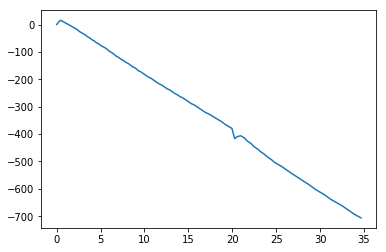

In [69]:
plt.plot(dfB16['timeAtSave'].values*timeScale, 
         2900. *(dfB16['(2, 3)'].values - dfB16['(2, 3)'].values[0]))

## Get checkpoint times

In [70]:
times = []
szlocs = []
tmfiles = natsort.natsort(glob2.glob('../models/results/B/16/checkpoint/**/tmDict**'))
statefiles = natsort.natsort(glob2.glob('../models/results/B/16/checkpoint/**/state*'))
for i in range(len(tmfiles)):
    out = np.load(tmfiles[i])
    d = dict(out)
    szlocs.append(d[2][3]['loc'] -  (30./2900.) )
    
    out = np.load(statefiles[i])
    d = dict(out)
    times.append(d['time'])

print( (np.array(times)*timeScale)[18] )
print( (np.array(times)*timeScale)[22] )

20.6001000394
27.1135195885


In [71]:
#out = np.load(statefiles[3])
#d = dict(out)
#(d['time']*timeScale)
#len(statefiles)

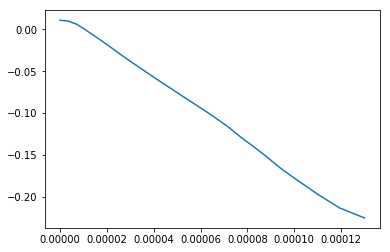

In [72]:
plt.plot(times, gaussian_filter(szlocs, 1) )

## Plot rollback vs Interface -arc 

In [73]:
checkindex = 17


#Interface data
intFiles = natsort.natsort(glob2.glob('../models/results/{}/{}/checkpoint/**/**f_2**h5'.format(Mod,Num)))

hf = h5py.File(intFiles[checkindex], 'r')
interface = np.array(hf.get("data"))[:,:]
mask = np.argsort(interface[:,0])
interface = interface[mask]


intList = []
for i in range(len(intFiles )):
    hf = h5py.File(intFiles[i], 'r')
    interface_ = np.array(hf.get("data"))[:,:]
    
    mask = np.argsort(interface_[:,0])
    
    intList.append(interface_[mask])
    
    
    
midFiles = natsort.natsort(glob2.glob('../models/results/{}/{}/checkpoint/**/**mid**h5'.format(Mod,Num)))



midList = []
for i in range(len(midFiles )):
    hf = h5py.File(midFiles[i], 'r')
    interface_ = np.array(hf.get("data"))[:,:]
    
    mask = np.argsort(interface_[:,0])
    midList.append(interface_[mask])

In [74]:
cs = sns.color_palette("coolwarm", len(times[14:26]))

In [75]:
#len(intList)

[]

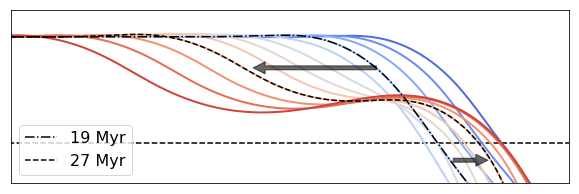

In [76]:
fig, ax = plt.subplots(figsize=(10,5))

arcLocs = []
arcSlabDepth = 120.

ci = 0
for f in midList[14:26]:
    depths = 2900.*(1. - f[:,1])
    ix_ = np.argmin(np.abs(depths - arcSlabDepth ))
    arcLocs.append(f[ix_,0])
    ax.plot(f[:,0]*2900., (1. -f[:,1])*2900,  lw = 2, c = cs[ci])
    
    #ax.vlines(f[ix_,0]*2900., 2750, 2900, linewidths = 0.5, color = cs[ci])
    ci += 1
    
    
time_ = timeScale*np.array(times)[17]
ax.plot(midList[17][:,0]*2900., 
        (1. -midList[17][:,1])*2900, ls = '-.',  c = 'k', label = '{0:0.0f} Myr'.format(time_))
    

time_ = timeScale*np.array(times)[22]
ax.plot(midList[22][:,0]*2900., 
        (1. - midList[22][:,1])*2900, ls = '--',  c = 'k', label = '{0:0.0f} Myr'.format(time_))




ax.legend(loc = 3, fontsize = 16)
ax.set_xlim(-0.25*2900, 0.*2900)
ax.set_ylim(150, 0)

ax.hlines((arcSlabDepth - 5), -800, 300, linestyles = '--')

#ax.set_ylim(0.85*2900, 1*2900)

ax.set_aspect(1.5)

ax.annotate('', xy=(-410, 50), xytext=(-250, 50), 
            arrowprops=dict(facecolor='black', shrink=0., alpha = 0.6),
            )


ax.annotate('', xy=(-105, 130), xytext=(-150, 130), 
            arrowprops=dict(facecolor='black', shrink=0., alpha = 0.6),
            )

ax.xaxis.set_ticklabels([])  
ax.xaxis.set_ticks([])
ax.yaxis.set_ticklabels([])  
ax.yaxis.set_ticks([])    

In [77]:
#fig.savefig('midPlane_2.png'.format(checkindex), 
#            dpi=250, bbox_inches='tight')

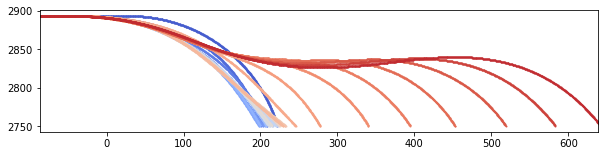

In [78]:
cs = sns.color_palette("coolwarm", len(times[:]))

fig, ax = plt.subplots(figsize=(10,4))

arcLocs = []
arcSlabDepth = 120.

ci = 0
for f in intList[:]:
    depths = 2900.*(1. - f[:,1])
    ix_ = np.argmin(np.abs(depths - arcSlabDepth ))
    arcLocs.append(f[ix_,0])
    ax.scatter((f[:,0]- szlocs[ci])*2900., f[:,1]*2900,  s = 1, c = cs[ci])
    
    #ax.vlines(f[ix_,0]*2900., 2750, 2900, linewidths = 0.5, color = cs[ci])
    ci += 1
    #print(ci)
    
ax.set_xlim(-0.03*2900, 0.22*2900)

#ax.hlines(2900. - (arcSlabDepth - 5), -800, 300)

#ax.set_ylim(0.85*2900, 1*2900)

ax.set_aspect(1)

In [79]:
cmpy = 2.0
gradkmpma = cmpy*1e-2*1e3


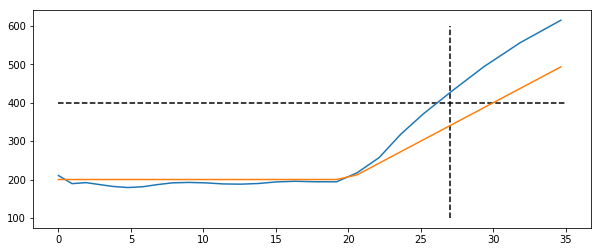

In [80]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(timeScale*np.array(times),
         -2900.*(np.array(szlocs) - np.array(arcLocs)) )



ax.plot(timeScale*np.array(times), 
        np.maximum(200, 200 + (timeScale*(np.array(times)) - 20.)*gradkmpma))

ax.hlines(400, 0, 35, linestyles='--')
ax.vlines(27, 100, 600, linestyles='--')

## velocity - stagnation

In [262]:
checkindex = 16

#Temp data
tempFiles = natsort.natsort(glob2.glob('../models/results/{}/{}/checkpoint/**/**temperatureField**h5'.format(Mod,Num)))

hf = h5py.File(tempFiles[checkindex], 'r')
temp = np.array(hf.get("data"))[:,0]
temp0 = temp.copy()*tempScale
temp += adiabatTempGrad*( 1. - meshData[:,1])
temp*=tempScale


#Temp data
velFiles = natsort.natsort(glob2.glob('../models/results/{}/{}/checkpoint/**/**vel**h5'.format(Mod,Num)))
hf = h5py.File(velFiles[checkindex ], 'r')
vel = np.array(hf.get("data"))[:,:]

In [263]:
midplane = midList[checkindex]
fy = CubicSpline(midplane[:,0], midplane[:,1])  
y1_ = fy.derivative(1)(midplane[:,0])
angle = np.arctan(y1_)
xs = np.cos(angle)
ys = np.sin(angle)

In [264]:
#build kdtree to map midplane to velocity
ourTree = kdTree(midplane)
d, p  = ourTree.query(meshData , 1)

localAngle = np.zeros(vel.shape)

localAngle[:,0] = xs[p]
localAngle[:,1] = ys[p]

In [265]:
#normalise the velocity
norm = numpy.fmax(1.0, numpy.linalg.norm(vel.copy(), axis=1))
velnorm = vel.copy() / norm[:, numpy.newaxis]


stagField = np.einsum('ij,ij->i', velnorm, localAngle)
vField.data[:] = velnorm
vData = vField.evaluate(midplane)

In [266]:
stagField.max(), stagField.min()

(0.99999999999999878, -0.9999999999778858)

In [267]:
#Temp grad

tField.data[:,0] = temp0[:]
tgradFn = tField.fn_gradient
tgradData = tgradFn.evaluate(mesh)
norm = numpy.fmax(1.0, numpy.linalg.norm(tgradData, axis=1))
res = tgradData / norm[:, numpy.newaxis]

#90 degrees rotation
#res = np.column_stack((-1.*res[:,1], res[:,0]))
stagField = np.einsum('ij,ij->i', res, velnorm)

#res[:,0]*= np.sign(test )


#vField.data[:] = res
#stagField = np.einsum('ij,ij->i', res, localAngle)

In [268]:
#stagField.max()

In [269]:
#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Surface(mesh, fn.math.dot(vField, vField), onMesh = True))
#fig.show()

In [270]:
#stagField.min()

In [271]:
#fig.savefig('midPlaneVel.png'.format(checkindex), 
#            dpi=250, bbox_inches='tight')

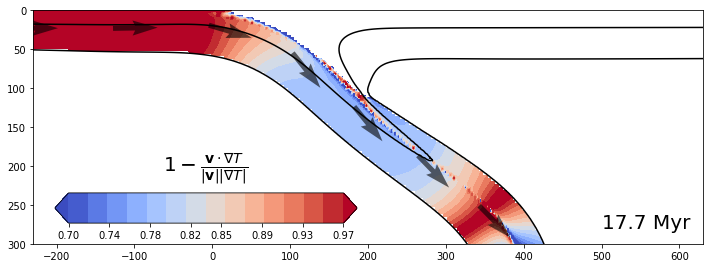

In [280]:
fig, ax = plt.subplots(figsize=(12,6)) 


#ax.plot(2900.*(midplane[:,0] - szlocs[checkindex]), 
#        2900.*(1. - midplane[:,1]), lw = 2, ls = '--', c = 'k', alpha = 0.6)



triang = mtri.Triangulation(2900*(meshData[:,0] -  szlocs[checkindex]), 2900*(1. - meshData[:,1]))  # Delaunay triangulation of all points.
point_mask = np.logical_or(temp0 > 1250., 
                            velnorm[:,0] < 0.)

tri_mask = np.any(point_mask[triang.triangles], axis=1)  # Triangles to mask out.
triang.set_mask(tri_mask)

#
#con = ax.tricontourf(triang, stagField, 
#               cmap = 'coolwarm'), 
#               levels = np.linspace(0.95, 1, 25), 
#               vmin = 0.95, vmax = 1.0, extend = 'min')


con = ax.tricontourf(triang, 1. - np.abs(stagField), 
               cmap = 'coolwarm', vmin = 0.7, vmax = 0.97, 
                     extend = 'both', levels = np.linspace(0.7, 0.97, 15), )
               

tempContour = ax.tricontour(2900*(meshData[:,0] - szlocs[checkindex]), 2900*(1. - meshData[:,1]),  
                    temp0,
                    levels = [600, 1250.] , 
                    colors= 'k', linewidths = 1.5 )

qi = 200
quiv = ax.quiver(2900*(midplane[:,0][::qi] - szlocs[checkindex]), 
                 2900*(1. -midplane[:,1][::qi]),
                 vData[:,0][::qi], vData[:,1][::qi], pivot = 'middle',
                 scale = 15, headlength = 5, headwidth = 3, alpha = 0.6 )


cbaxes = fig.add_axes([0.15, 0.28, 0.35, 0.07]) 
cb1 = colorbar(con, cax = cbaxes, orientation="horizontal") 
##cb1.set_label(r'$\frac{(v_s \cdot \hat s)}{|v_s|}$', size= 20, labelpad=-90)
cb1.set_label(r'$ 1 - \frac{\mathbf{v} \cdot \nabla T}{\| \mathbf{v} \| \| \nabla T \|}$', size= 20, labelpad=-90)
cb1.set_ticks(np.round(cb1.get_ticks(), 2)[::1] )



time_ = timeScale*np.array(times)[checkindex]
#ax.text( -200 , 280, '{0:0.1f} Myr'.format(time_), fontsize = 20)
ax.text( 500 , 280, '{0:0.1f} Myr'.format(time_), fontsize = 20)


ax.set_xlim(-230, 630)
ax.set_ylim(300, 0)
ax.set_aspect('equal')


In [281]:
#fig.savefig('stagnation/fig_{}_.png'.format(checkindex), 
#            dpi=100, bbox_inches='tight')

## Plot mid-plane and vectors

In [ ]:
mask = vData[:,1] > 0.


fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(2900.*(midplane[:,0] - szlocs[checkindex]), 2900.*(1. - midplane[:,1]),  s = 5)
ax.scatter(2900.*(midplane[mask,0] - szlocs[checkindex]), 
           2900.*(1. - midplane[mask,1]), c = 'r', s = 5)

qi = 200
quiv = ax.quiver(2900.*(midplane[:,0][::qi] - szlocs[checkindex]), 2900.*(1. - midplane[:,1][::qi]),
         vData[:,0][::qi], vData[:,1][::qi], pivot = 'middle',
                headlength = 5, headwidth = 3 )

#ax.set_xlim(-0.35, 0.1)
ax.set_xlim(-300, 600)
ax.set_ylim(200, 0)

ax.set_aspect(1)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))


offset = 0.
for i in range(14, 26):
    hf = h5py.File(velFiles[i], 'r')
    vel = np.array(hf.get("data"))[:,:]
    
    midplane = midList[i]
    
    
    
    norm = numpy.fmax(1.0, numpy.linalg.norm(vel.copy(), axis=1))
    velnorm = vel.copy() / norm[:, numpy.newaxis]
    stagField = np.einsum('ij,ij->i', velnorm, localAngle)
    vField.data[:] = velnorm

    vData = vField.evaluate(midplane)
    mask =  vData[:,1] < 0. 
    
    maskXs = np.ma.masked_where(vData[:,1] < 0. , midplane[:,0])
    maskYs = np.ma.masked_where(vData[:,1] < 0. , midplane[:,1])
    
    ax.scatter(2900.*(midplane[mask,0] - szlocs[i]), 
               2900.*(1. - midplane[mask,1]) + offset,  s= 0.05, c = 'k', alpha = 0.7)
    ax.plot(2900.*(maskXs - szlocs[i]), 
               2900.*(1. -  maskYs) + offset, c = 'r', lw = 3)

    qi = 200
    quiv = ax.quiver(2900.*(midplane[:,0][:-500:qi] - szlocs[i]), 2900.*(1. - midplane[:,1][:-500:qi]) + offset,
             vData[:,0][:-500:qi], vData[:,1][:-500:qi], pivot = 'middle',
                    headlength = 5, headwidth = 3 , alpha = 0.6, scale=20, zorder = 100)
    
    
    offset += 80
    
    time_ = timeScale*np.array(times)[i]
    
    ax.text( -350 , -15 + offset, '{0:0.1f} Myr'.format(time_), fontsize = 20)
    
ax.plot([-1000, -1000], [-1000, -1000], c= 'r', lw = 3, label = r'$v_y > 0.$')
    
ax.legend(fontsize = 16)

ax.set_xlim(-360, 660)
ax.set_ylim(1000, 0)
ax.set_aspect(1)
    
ax.yaxis.set_ticklabels([])

## Isotherm arc location

In [595]:
#trench

In [596]:
p1 = tempContour.collections[-1].get_paths()

pv = [path.vertices for path in p1]
Iso1 = np.concatenate(pv) #already dimensionalized

midplane = intList[checkindex] 
fy2 = CubicSpline( 2900.*(midplane[:,0] - szlocs[checkindex]), 2900.*(1. - midplane[:,1]) )  

#mask1 = Iso1[:,1] < fy2(Iso1[:,0])       
mask1 = np.logical_and(Iso1[:,1] < fy2(Iso1[:,0]), 
                       np.logical_and(Iso1[:,1] > 20., Iso1[:,0] > 0. ))

(800, 0)

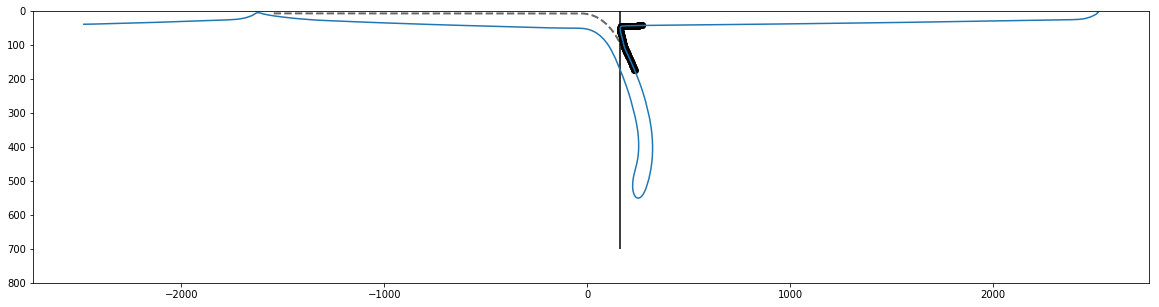

In [614]:
fig, ax = plt.subplots(figsize=(20, 5))


ax.plot(Iso1[:,0], 
        Iso1[:,1])


ax.scatter(Iso1[mask1,0], 
        Iso1[mask1,1],  c = 'k')

ax.plot(2900.*(midplane[:,0] - szlocs[checkindex]), 
        2900.*(1. - midplane[:,1]), lw = 2, ls = '--', c = 'k', alpha = 0.6)

ax.vlines(Iso1[mask1,0].min(), 
         0, 700)

ax.set_ylim(800, 0)
#ax.set_xlim(0, 800)

In [599]:
Iso1[mask1,0].min()

194.43241313867509

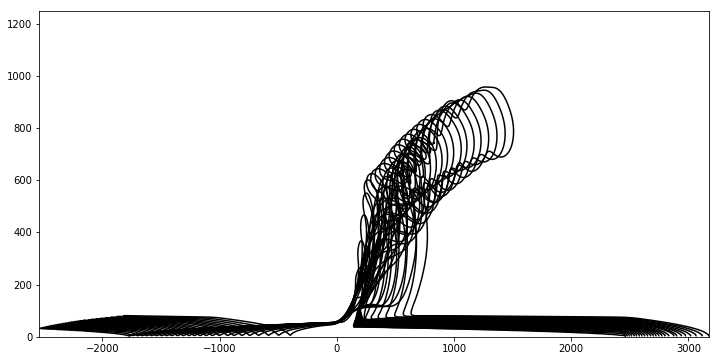

In [615]:
arcLocTemp = []

fig, ax = plt.subplots(figsize=(12,6)); 

for i in range(0, len(times)):
    
    hf = h5py.File(tempFiles[i], 'r')
    temp = np.array(hf.get("data"))[:,0]
    temp0 = temp.copy()*tempScale
    temp += adiabatTempGrad*( 1. - meshData[:,1])
    temp*=tempScale
    
    ##########
    tempContour = ax.tricontour(2900*(meshData[:,0] - szlocs[i]), 2900*(1. - meshData[:,1]),  
    temp0,
    levels = [1250.] , 
    colors= 'k', linewidths = 1.5 )
    
    ##########
    p1 = tempContour.collections[0].get_paths()
    pv = [path.vertices for path in p1]
    Iso1 = np.concatenate(pv) #already dimensionalized
    midplane = intList[i] 
    fy2 = CubicSpline( 2900.*(midplane[:,0] - szlocs[i]), 2900.*(1. - midplane[:,1]) )  
    mask1 = np.logical_and(Iso1[:,1] < fy2(Iso1[:,0]), 
                       np.logical_and(Iso1[:,1] > 20., Iso1[:,0] > 0. ))
    
    
    ##########
    arcLocTemp.append(Iso1[mask1,0].min())
    
    

    

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))


ax.plot(Iso1[:,0], 
        Iso1[:,1])


ax.scatter(Iso1[mask1,0], 
        Iso1[mask1,1],  c = 'k')

ax.plot(2900.*(midplane[:,0] - szlocs[i]), 
        2900.*(1. - midplane[:,1]), lw = 2, ls = '--', c = 'k', alpha = 0.6)

ax.vlines(Iso1[mask1,0].min(), 
         0, 700)

ax.set_ylim(800, 0)
#ax.set_xlim(0, 800)

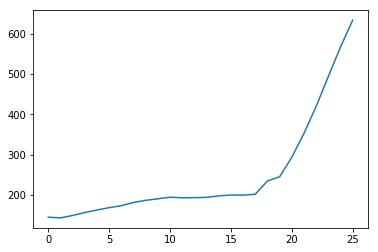

In [616]:
plt.plot(arcLocTemp)

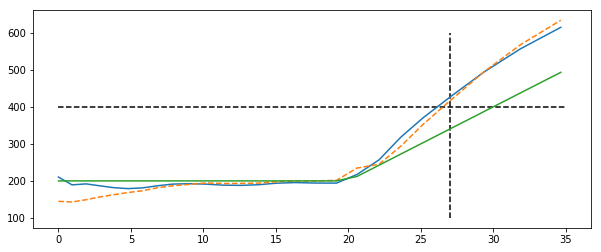

In [622]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(timeScale*np.array(times),
         -2900.*(np.array(szlocs) - np.array(arcLocs)) )


ax.plot(timeScale*np.array(times),
          np.array(arcLocTemp), ls = '--' )

ax.plot(timeScale*np.array(times), 
        np.maximum(200, 200 + (timeScale*(np.array(times)) - 20.)*gradkmpma))

ax.hlines(400, 0, 35, linestyles='--')
ax.vlines(27, 100, 600, linestyles='--')

## Save data

In [626]:
#np.savetxt('arc_loc_model/times' , timeScale*np.array(times))
#np.savetxt('arc_loc_model/arcLocTemp' , np.array(arcLocTemp))
#np.savetxt('arc_loc_model/arcLocSlab' , -2900.*(np.array(szlocs) - np.array(arcLocs)))

In [324]:
#plt.plot(testDf['timeAtSave'].values*timeScale, 
#         2900. *(testDf['(2, 3)'].values - testDf['(2, 3)'].values[0])

## To do

* find a way to plot velocities in the slab during flattenign - to make the point about the slab not lifting

* simple way to plot the trench arc trends. Coudl use isotherms, or instead just use 100 km location of slab top

* plot the velocity midpland dot-product field

In [98]:
#testDf['timeAtSave'].values

In [99]:
#testDf